In [2]:
import numpy as np
from tqdm.notebook import tqdm, trange
from alive_progress import alive_bar
import time # to be used in loop iterations
import caffeine
from multiprocess import Pool
import matplotlib.pyplot as plt
from queue import Queue
from threading import Thread
np.random.seed(1234)

In [148]:
#Ground truth data distribution
def random_sample(d, Delta, N):
    y = np.ones(N)
    x = np.zeros((N,d))
    successes = np.random.binomial(N, 0.5)
    y[successes:] *= -1
    x[:successes, :] = np.random.multivariate_normal([0]*d, np.diag([(1+Delta)**2]*d), successes)
    x[successes:, :] = np.random.multivariate_normal([0]*d, np.diag([(1-Delta)**2]*d), N-successes)
    x = np.take(x,np.random.rand(x.shape[0]).argsort(),axis=0,out=x)
    
    return x.reshape(N,d),y

In [83]:
#activation function
def sigma(t, t1, s1, t2, s2):
    if t < t1:
        return s1
    elif t>t2:
        return s2
    else:
        return (s2-s1)/(t2-t1)*(t-t1)+s1
    
def grad_sigma(t, t1, s1, t2, s2):
    if t < t1:
        return 0
    elif t>t2:
        return 0
    else:
        return (s2-s1)/(t2-t1)
vgrad_sigma = np.vectorize(grad_sigma)
vsigma = np.vectorize(sigma)

#non-monotone activation function
def sigma_nm(t):
    if t < 0:
        return -2.5
    elif t>1.5:
        return 7.5
    elif 0<=t<=0.5:
        return (-4+2.5)/(0.5)*(t)-2.5
    elif 0.5<=t<=1.5:
        return (11.5)*(t-0.5)-4
        
def grad_sigma_nm(t):
    if t < 0:
        return 0
    elif t>1.5:
        return 0
    elif 0<=t<=0.5:
        return (-4+2.5)/(0.5)
    elif 0.5<=t<=1.5:
        return (11.5)
vgrad_sigma_nm = np.vectorize(grad_sigma_nm)
vsigma_nm = np.vectorize(sigma_nm)

In [88]:
#two layer neural net
def neural_net(x, θ):
    n = x.shape[0]
    out = vsigma(θ@x.T, 0.5, -2.5, 1.5, 7.5)
    return np.mean(out, axis = 0).reshape(n,1)
#two layer neural net with non-monotone activation
def neural_net_nm(x, θ):
    n = x.shape[0]
    out = vsigma_nm(θ@x.T)
    return np.mean(out, axis = 0).reshape(n,1)

In [358]:
def stochastic_gradient_descent(weights, d, Delta, N, epsilon = 1e-6, num_epochs = 1000):
    indices = [int(a) for a in 10**(np.linspace(0.7, np.log10(num_epochs), 60))]
    risk = []
    steps = epsilon*(epsilon*np.arange(1,num_epochs+1))**(-0.25)
    for epoch in trange(1,num_epochs+1): 
        # Update the weights
        sample = random_sample(d,Delta,1)
        X = sample[0].reshape(1,d)
        y = sample[1]
        vgrad = vgrad_sigma_nm(weights@X.T)
        gradient = vgrad.reshape(N,1)*(X).reshape(1,d)
        weights += 2*steps[epoch-1]*(y-neural_net_nm(X, weights))*gradient
        if epoch in indices:
        #population risk
            M = int(1e3)
            x_sample, y_sample = random_sample(d, Delta, M)
            mse = np.mean((y_sample-neural_net_nm(x_sample,weights))**2)
            risk.append(mse)
            print('Epoch: {}, risk: {}'.format(epoch, mse))
                
    return weights, np.array(risk), indices

In [357]:
#params
d = 320
N = 800
Delta = 0.5
kappa = 0.1

# Initialize random weights
weights = np.random.multivariate_normal([0]*d, np.diag([(kappa)**2/d]*d), N).reshape(N, d)

weights,risk, indices = stochastic_gradient_descent(weights, d, Delta, N, epsilon = 1e-5, num_epochs = int(1e4))

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 5, risk: 8.154035543017622
Epoch: 6, risk: 8.062966417506752
Epoch: 7, risk: 8.130753298363567
Epoch: 8, risk: 8.09488084163358
Epoch: 9, risk: 8.149434997675032
Epoch: 10, risk: 8.140866899757738


KeyboardInterrupt: 

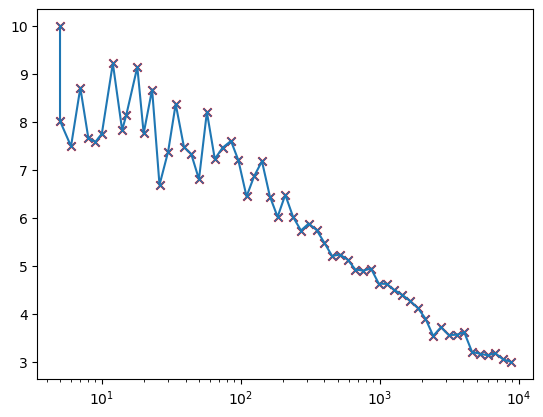

In [306]:
indices = [int(a) for a in 10**(np.linspace(0.7, 4, 60))]

fig, ax = plt.subplots()
ax.scatter(indices[:-1], risk, marker = 'x', c = 'r')
ax.plot(indices[:-1], risk, marker = 'x')
ax.set_xscale('log')
plt.show()

In [312]:
from scipy.stats import norm

def q_plus(t, Delta):
    x = np.linspace(0.5/((1+Delta)*t), 1.5/((1+Delta)*t), 100)
    f = 1 / (np.sqrt(2 * np.pi)) * vsigma((1 + Delta) * t * x, 0.5, -2.5, 1.5, 7.5) * np.exp(-x ** 2 / 2)
    integral = np.trapz(f, x)
    return integral -2.5*norm.cdf(0.5/((1+Delta)*t))+7.5*(1-norm.cdf(1.5/((1+Delta)*t)))
    #return integral

def q_minus(t, Delta):
    x = np.linspace(0.5/((1-Delta)*t), 1.5/((1-Delta)*t), 100)
    f = 1 / (np.sqrt(2 * np.pi)) * vsigma((1 - Delta) * t * x, 0.5, -2.5, 1.5, 7.5) * np.exp(-x ** 2 / 2)
    integral = np.trapz(f, x)
    return integral -2.5*norm.cdf(0.5/((1-Delta)*t))+7.5*(1-norm.cdf(1.5/((1-Delta)*t)))
    #return integral

vq_plus = np.vectorize(q_plus)
vq_minus = np.vectorize(q_minus)

def dq_plus(t, Delta):
    x = np.linspace(0.5/((1+Delta)*t), 1.5/((1+Delta)*t), 100)
    f = (1+Delta) / (np.sqrt(2 * np.pi)) * 10 * np.exp(-x ** 2 / 2)*x
    integral = np.trapz(f, x)
    return integral 

def dq_minus(t, Delta):
    x = np.linspace(0.5/((1-Delta)*t), 1.5/((1-Delta)*t), 100)
    f = (1-Delta) / (np.sqrt(2 * np.pi)) * 10 * np.exp(-x ** 2 / 2)*x
    integral = np.trapz(f, x)
    return integral
    
vdq_plus = np.vectorize(dq_plus)
vdq_minus = np.vectorize(dq_minus)

def q_func(pair):
    t = pair[0]
    flag = pair[1]
    if flag == 0:
        return vq_plus(t,0.8)
    elif flag == 1:
        return vq_minus(t,0.8)
    elif flag == 2:
        return vdq_plus(t,0.8)
    elif flag == 3:
        return vdq_minus(t,0.8)
    
def q_func_new(pair):
    t = pair[0]
    flag = pair[1]
    if flag == 0:
        return vq_plus_new(t)
    elif flag == 1:
        return vq_minus_new(t)
    elif flag == 2:
        return vdq_plus_new(t)
    elif flag == 3:
        return vdq_minus_new(t)

def parallelise(t):
    with Pool(4) as p:
        results = np.array(p.map(q_func_new, [[t,0], [t,1], [t,2], [t,3]]))
    return results
vparallelise = np.vectorize(parallelise)

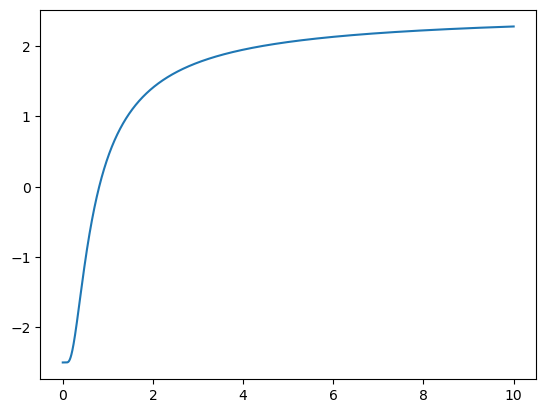

In [313]:
epsilon = 1e-6
Delta = 0.8
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
q_plus_vals = vq_plus(Interval_q, Delta)
plt.plot(Interval_q, q_plus_vals)

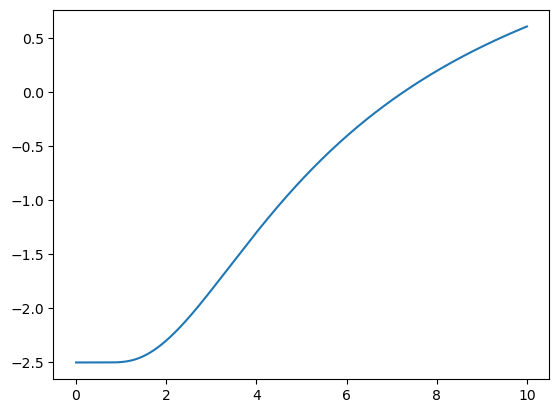

In [314]:
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
q_minus_vals = vq_minus(Interval_q, Delta)
plt.plot(Interval_q, q_minus_vals)

In [315]:
Q_plus = dict(zip(Interval_q, q_plus_vals))
Q_minus = dict(zip(Interval_q, q_minus_vals))

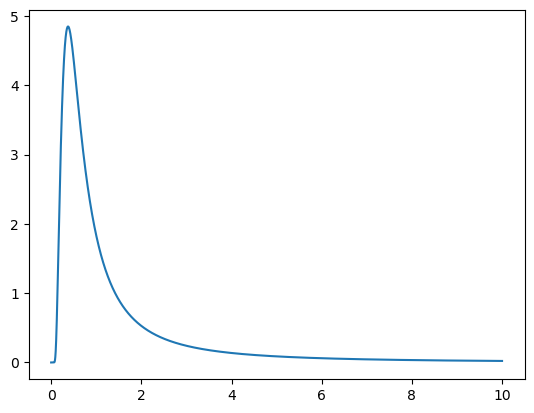

In [316]:
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
dq_plus_vals = vdq_plus(Interval_q, Delta)
plt.plot(Interval_q, dq_plus_vals)

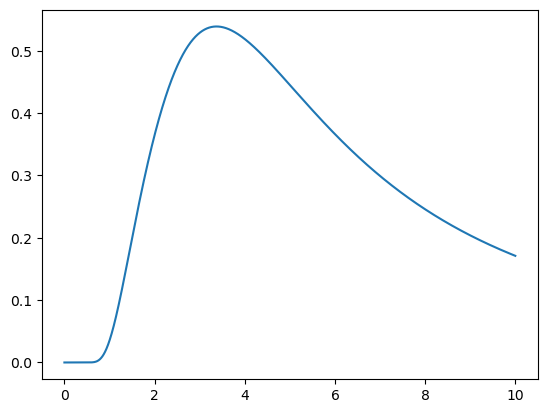

In [317]:
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
dq_minus_vals = vdq_minus(Interval_q, Delta)
plt.plot(Interval_q, dq_minus_vals)

In [318]:
dQ_plus = dict(zip(Interval_q, dq_plus_vals))
dQ_minus = dict(zip(Interval_q, dq_minus_vals))

In [319]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
vfind_nearest = np.vectorize(find_nearest)

In [320]:
def q_plus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return Q_plus[r_approx]

def q_minus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return Q_minus[r_approx]

vq_plus_new = np.vectorize(q_plus_new)
vq_minus_new = np.vectorize(q_minus_new)

def dq_plus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return dQ_plus[r_approx]

def dq_minus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return dQ_minus[r_approx]

vdq_plus_new = np.vectorize(dq_plus_new)
vdq_minus_new = np.vectorize(dq_minus_new)


def R_inf(vq_plus, vq_minus, Delta):
    mean_vq_plus = np.mean(vq_plus)
    mean_vq_minus = np.mean(vq_minus)
    return 0.5 * (1 - mean_vq_plus) ** 2 + 0.5 * (1 + mean_vq_minus) ** 2

def grad_R_inf(r, vq_plus, vq_minus, dplus, dminus, Delta):
    J = len(r)
    mean_vq_plus = np.mean(vq_plus)
    mean_vq_minus = np.mean(vq_minus)
    return -1 / J * dplus * (1 - mean_vq_plus) + 1 / J * dminus * (1 + mean_vq_minus)

def update(r, dt, grad):
    J = len(r)
    return J * grad * dt

In [363]:
#simulate pde
epsilon = 1e-5
Interval = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e3))
J = 400
Delta = 0.5
d = 320
Kappa = 0.4
separations = [Interval[k+1]-Interval[k] for k in range(len(Interval)-1)]

In [364]:
processes_count = 4
pde_risk = np.zeros(Interval.shape[0])
Z = np.random.multivariate_normal([0]*d, np.diag([(Kappa)**2/d]*d), J).reshape(J, d)
r = np.linalg.norm(Z, axis = 1)
for k in trange(len(separations)):
    dt = separations[k]
    plus = vq_plus(r, Delta)
    minus = vq_minus(r, Delta)
    dplus = vdq_plus(r, Delta)
    dminus = vdq_minus(r, Delta)
    '''
    output = parallelise(r).reshape(4,J)
    plus = output[0]
    minus = output[1]
    dplus = output[2]
    dminus = output[3]
    '''
    inf_risk = R_inf(plus, minus, Delta)
    pde_risk[k] = inf_risk
    print('Epoch: {}, risk: {}'.format(k, inf_risk))
    grad = grad_R_inf(r, plus, minus, dplus, dminus, Delta)
    r = r - (Interval[k])**(-0.25)*update(r,dt, grad)
plus = vq_plus(r, Delta)
minus = vq_minus(r, Delta)
dplus = vdq_plus(r, Delta)
dminus = vdq_minus(r, Delta)
inf_risk = R_inf(plus, minus, Delta)
pde_risk[-1] = inf_risk

  0%|          | 0/999 [00:00<?, ?it/s]

Epoch: 0, risk: 5.130039540741927
Epoch: 1, risk: 5.13003942668243
Epoch: 2, risk: 5.130039310232173
Epoch: 3, risk: 5.130039191341042
Epoch: 4, risk: 5.130039069957873
Epoch: 5, risk: 5.130038946030435
Epoch: 6, risk: 5.130038819505398
Epoch: 7, risk: 5.130038690328313
Epoch: 8, risk: 5.130038558443591
Epoch: 9, risk: 5.130038423794478
Epoch: 10, risk: 5.1300382863230345
Epoch: 11, risk: 5.130038145970098
Epoch: 12, risk: 5.130038002675276
Epoch: 13, risk: 5.1300378563768945
Epoch: 14, risk: 5.130037707012008
Epoch: 15, risk: 5.130037554516337
Epoch: 16, risk: 5.130037398824255
Epoch: 17, risk: 5.130037239868765
Epoch: 18, risk: 5.130037077581466
Epoch: 19, risk: 5.1300369118925175
Epoch: 20, risk: 5.130036742730623
Epoch: 21, risk: 5.1300365700229875
Epoch: 22, risk: 5.130036393695281
Epoch: 23, risk: 5.1300362136716355
Epoch: 24, risk: 5.130036029874577
Epoch: 25, risk: 5.130035842225014
Epoch: 26, risk: 5.130035650642193
Epoch: 27, risk: 5.13003545504367
Epoch: 28, risk: 5.13003525

Epoch: 231, risk: 5.129389142204294
Epoch: 232, risk: 5.129375395674463
Epoch: 233, risk: 5.12936136102157
Epoch: 234, risk: 5.129347032206929
Epoch: 235, risk: 5.129332403065302
Epoch: 236, risk: 5.129317467302252
Epoch: 237, risk: 5.1293022184914285
Epoch: 238, risk: 5.12928665007181
Epoch: 239, risk: 5.12927075534488
Epoch: 240, risk: 5.129254527471747
Epoch: 241, risk: 5.1292379594702
Epoch: 242, risk: 5.129221044211708
Epoch: 243, risk: 5.129203774418359
Epoch: 244, risk: 5.129186142659721
Epoch: 245, risk: 5.129168141349659
Epoch: 246, risk: 5.129149762743055
Epoch: 247, risk: 5.129130998932493
Epoch: 248, risk: 5.129111841844858
Epoch: 249, risk: 5.129092283237854
Epoch: 250, risk: 5.129072314696463
Epoch: 251, risk: 5.129051927629344
Epoch: 252, risk: 5.129031113265103
Epoch: 253, risk: 5.129009862648563
Epoch: 254, risk: 5.128988166636878
Epoch: 255, risk: 5.128966015895629
Epoch: 256, risk: 5.12894340089479
Epoch: 257, risk: 5.128920311904643
Epoch: 258, risk: 5.1288967389915

Epoch: 461, risk: 5.052847917119905
Epoch: 462, risk: 5.051235194883988
Epoch: 463, risk: 5.049588918215147
Epoch: 464, risk: 5.047908395691971
Epoch: 465, risk: 5.046192921987764
Epoch: 466, risk: 5.044441777609038
Epoch: 467, risk: 5.04265422863012
Epoch: 468, risk: 5.040829526423828
Epoch: 469, risk: 5.038966907388276
Epoch: 470, risk: 5.037065592669774
Epoch: 471, risk: 5.035124787881867
Epoch: 472, risk: 5.033143682820519
Epoch: 473, risk: 5.031121451175502
Epoch: 474, risk: 5.029057250237968
Epoch: 475, risk: 5.026950220604311
Epoch: 476, risk: 5.02479948587632
Epoch: 477, risk: 5.022604152357715
Epoch: 478, risk: 5.020363308747102
Epoch: 479, risk: 5.018076025827432
Epoch: 480, risk: 5.015741356152072
Epoch: 481, risk: 5.013358333727541
Epoch: 482, risk: 5.0109259736930465
Epoch: 483, risk: 5.0084432719969225
Epoch: 484, risk: 5.005909205070107
Epoch: 485, risk: 5.003322729496796
Epoch: 486, risk: 5.000682781682421
Epoch: 487, risk: 4.997988277519134
Epoch: 488, risk: 4.99523811

Epoch: 687, risk: 1.5291289651929914
Epoch: 688, risk: 1.5035113767570203
Epoch: 689, risk: 1.478067547101106
Epoch: 690, risk: 1.4527999159416547
Epoch: 691, risk: 1.427710860895652
Epoch: 692, risk: 1.4028027016722866
Epoch: 693, risk: 1.3780777041636496
Epoch: 694, risk: 1.3535380844165394
Epoch: 695, risk: 1.3291860124681278
Epoch: 696, risk: 1.305023616029158
Epoch: 697, risk: 1.2810529839989306
Epoch: 698, risk: 1.2572761697974033
Epoch: 699, risk: 1.2336951945004477
Epoch: 700, risk: 1.2103120497652613
Epoch: 701, risk: 1.1871287005339681
Epoch: 702, risk: 1.1641470875042632
Epoch: 703, risk: 1.14136912935713
Epoch: 704, risk: 1.1187967247326382
Epoch: 705, risk: 1.0964317539458541
Epoch: 706, risk: 1.0742760804361824
Epoch: 707, risk: 1.0523315519443894
Epoch: 708, risk: 1.0306000014129184
Epoch: 709, risk: 1.0090832476062104
Epoch: 710, risk: 0.9877830954489473
Epoch: 711, risk: 0.9667013360815104
Epoch: 712, risk: 0.9458397466330293
Epoch: 713, risk: 0.9252000897138544
Epoch:

Epoch: 903, risk: 0.0031210334258307496
Epoch: 904, risk: 0.003121023519344629
Epoch: 905, risk: 0.0031210133290155936
Epoch: 906, risk: 0.0031210028444591522
Epoch: 907, risk: 0.0031209920550557013
Epoch: 908, risk: 0.003120980949861722
Epoch: 909, risk: 0.0031209695175442426
Epoch: 910, risk: 0.0031209577463296163
Epoch: 911, risk: 0.0031209456239613127
Epoch: 912, risk: 0.003120933137662598
Epoch: 913, risk: 0.0031209202741018603
Epoch: 914, risk: 0.0031209070193585035
Epoch: 915, risk: 0.003120893358888839
Epoch: 916, risk: 0.003120879277490927
Epoch: 917, risk: 0.003120864759267771
Epoch: 918, risk: 0.0031208497875887522
Epoch: 919, risk: 0.0031208343450488626
Epoch: 920, risk: 0.0031208184134255967
Epoch: 921, risk: 0.003120801973632999
Epoch: 922, risk: 0.003120785005672933
Epoch: 923, risk: 0.0031207674885833283
Epoch: 924, risk: 0.0031207494003828704
Epoch: 925, risk: 0.0031207307180123028
Epoch: 926, risk: 0.0031207114172716465
Epoch: 927, risk: 0.0031206914727533756
Epoch: 9

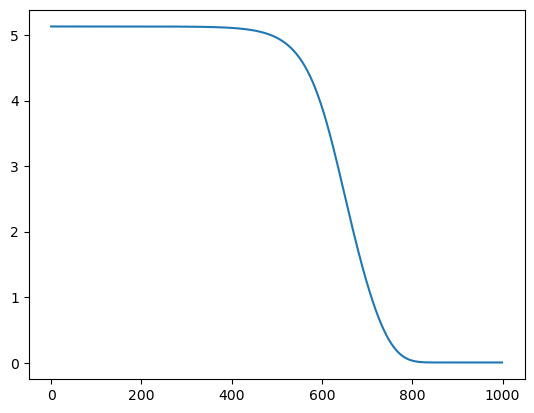

In [365]:
plt.plot(pde_risk)

In [406]:
discretised_pde = lambda k: pde_risk[np.abs(Interval - epsilon**(4/3)*k).argmin()]
iters = np.arange(0, int(1e2))
disc_pde_loss = np.vectorize(discretised_pde)

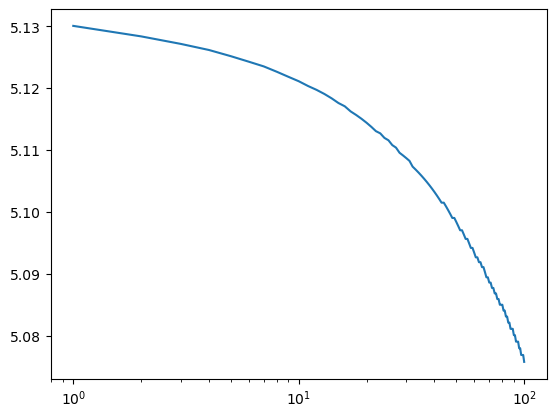

In [413]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, 1e2+1), disc_pde_loss(iters))
ax.set_xscale('log')
plt.show()

In [398]:
Interval[np.abs((Interval - epsilon**(4/3)*1e7)).argmin()]

2.1395888713434217

In [401]:
np.abs((Interval - epsilon**(4/3)*1e5)).argmin()

694

In [402]:
pde_risk[694]

1.3535380844165394